## Image segmentation using U-Nets (Data Science Bowl 2018)

#### Segmentation of nuclei in microscopy images
The segmentation of nuclei in microscopy images is a common task in many workflows. Most traditional image processing methods are created for one specific type of image, and perform poorly on others.

The aim is to develop a general-purpose algorithm to segment cell nuclei from any type of microscopy images.

<img src="assets/nuclei_image_types.png" style="width: 600px;"/>

---

We will use a U-Net Convolutional Neural Network to perform this task. This notebook is adapted from [Keras U-Net starter by Kjetil Åmdal-Sævik](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855) ([Licensed under the Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0))


**For more information, see the original publication about the 2018 Data Science Bowl:**

[Caicedo, J.C., Goodman, A., Karhohs, K.W. et al.
Nucleus segmentation across imaging experiments: the 2018 Data Science Bowl.
Nat Methods 16, 1247–1253 (2019)](https://doi.org/10.1038/s41592-019-0612-7)

We will be using some data from the original challenge (hosted at [https://www.kaggle.com/c/data-science-bowl-2018](https://www.kaggle.com/c/data-science-bowl-2018) (account required), and also from the [Broad Institute](https://bbbc.broadinstitute.org/BBBC038)).

#### **A copy of the data for this course is available [here](https://drive.google.com/file/d/1hlDAvRFH7Ax_Nxee4jCyN_IIDax-CLc8/view?usp=sharing)**

### We begin by loading and visualising some of the data

#### First download the data, unzip and move into the repository

In [1]:
import pooch
from pathlib import Path
data_path = Path.cwd().parent / "dsb_data"

In [2]:
# Use pooch to fetch data if it hasn't already been downloaded
dsb_data_url = "https://gin.g-node.org/neuroinformatics/image-analysis-courses/raw/master/dsb_2018/stage1_train.zip"
data_path = pooch.retrieve(dsb_data_url, known_hash="4e9fb804d2ff054d7bd83d4781c66e07dae9937207a09168330a5b5cefa0daba", processor=pooch.Unzip(extract_dir=data_path), progressbar=True)

In [3]:
data_path = Path(data_path[0]).parent.parent.parent
print(data_path)

/Users/adamtyson/projects/teaching/image-analysis-python/dsb_data/stage1_train


In [4]:
import os
import numpy as np

from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize

DEBUG = True  # Set to True to only load a fraction of the raw data


def load_images(
    data_path, image_width=128, image_height=128, num_channels=3, debug=False
):
    """
    :param data_path: Location of the data on disk (pathlib object)
    :param filenames: List of image paths
    :param image_width: Image width in pixels for resizing
    :param image_height: Image height in pixels for resizing
    :param num_channels: Final number of channels required

    :return images, masks: Numpy array of images, and segmentation masks
    """

    data_path = Path(data_path)

    filenames = next(os.walk(data_path))[1]
    if debug:
        filenames = filenames[:40]
        
    images = np.zeros(
        (len(filenames), image_height, image_width, num_channels),
        dtype=np.uint8,
    )
    masks = np.zeros((len(filenames), image_height, image_width, 1), dtype=bool)

    for n, image_id in tqdm(enumerate(filenames), total=len(filenames)):
        img = imread(data_path / image_id / "images" / (image_id + ".png"))[
            :, :, :num_channels
        ]
        img = resize(
            img,
            (image_height, image_width),
            mode="constant",
            preserve_range=True,
        )
        images[n] = img
        mask = np.zeros((image_height, image_width, 1), dtype=bool)

        mask_dir = data_path / image_id / "masks"
        for mask_file in next(os.walk(mask_dir))[2]:
            mask_ = imread(mask_dir / mask_file)
            mask_ = np.expand_dims(
                resize(
                    mask_,
                    (image_height, image_width),
                    mode="constant",
                    preserve_range=True,
                ),
                axis=-1,
            )
            mask = np.maximum(mask, mask_)
        masks[n] = mask
    return images, masks

In [5]:
images, masks = load_images(data_path, debug=DEBUG)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:07<00:00,  5.71it/s]


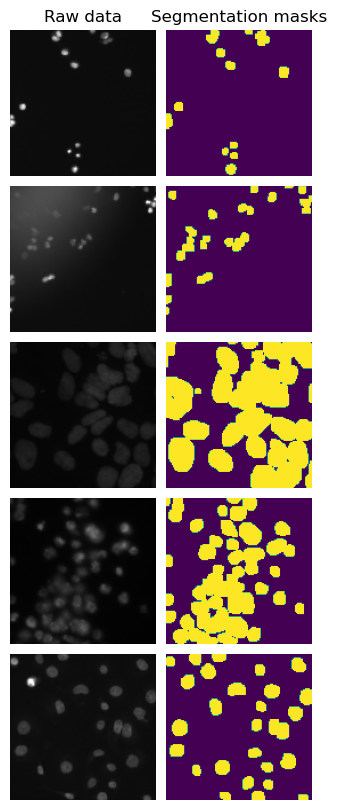

In [6]:
# Visualise some raw data and segmentation masks
import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


def plot_raw_data(raw_images, masks, num_to_plot=2, fig_size=(10, 10), axes_pad=0.1):
    """
    Plot raw data

    :param raw_images: Array of raw data images
    :param masks: Array of mask images
    :param num_to_plot: How many random images to plot
    :param fig_size: Tuple of overall figure size
    :param axes_pad: Seperation of individual images
    """

    idx_to_plot = tuple(random.sample(range(0, len(raw_images)), num_to_plot))

    raw_images = raw_images[tuple([idx_to_plot])]
    masks = np.squeeze(masks)[tuple([idx_to_plot])]

    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(num_to_plot, 2),
        axes_pad=axes_pad,
    )

    images = []
    for a, b in zip(raw_images, masks):
        images.extend([a, b])

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")

    grid[0].title.set_text("Raw data")
    grid[1].title.set_text("Segmentation masks")


plot_raw_data(images, masks, num_to_plot=5)

### Now we'll build a model to segment these images

We'll be using the popular [U-Net architecture](https://arxiv.org/abs/1505.04597)

<img src="assets/unet.png" style="width: 400px;"/>

In [7]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator


def build_unet(image_width=128, image_height=128, num_channels=3):
    inputs = Input((image_height, image_width, num_channels))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(8, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(16, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(16, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(32, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(32, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(64, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(64, (3, 3), activation="relu", padding="same")(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(128, (3, 3), activation="relu", padding="same")(p4)
    c5 = Conv2D(128, (3, 3), activation="relu", padding="same")(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(64, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(32, (3, 3), activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation="relu", padding="same")(u8)
    c8 = Conv2D(16, (3, 3), activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation="relu", padding="same")(u9)
    c9 = Conv2D(8, (3, 3), activation="relu", padding="same")(c9)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
import tensorflow as tf

model = build_unet()
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=[
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
    ],
)

### Split the dataset into a train (80%) and test (20%) fraction

In [9]:
from sklearn.model_selection import train_test_split

test_fraction = 0.2

(
    images_train,
    images_test,
    masks_train,
    masks_test,
) = train_test_split(
    images,
    masks,
    test_size=test_fraction,
)

### Train the model

In [ ]:
epochs = 200  # Number of iterations over the full dataset
batch_size = 32  # Number of samples per gradient update
validation_split = 0.1  # In addition to test dataset, use 10% of data to assess performance during training

model.fit(
    images_train,
    masks_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/200


2023-05-19 11:40:13.553514: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 2s 2s/step - loss: 0.9951 - mean_io_u: 0.3746 - recall: 0.8525 - precision: 0.2318 - val_loss: 0.7073 - val_mean_io_u: 0.3825 - val_recall: 0.8802 - val_precision: 0.2289
Epoch 2/200
1/1 [==============================] - 0s 417ms/step - loss: 0.9662 - mean_io_u: 0.3746 - recall: 0.8436 - precision: 0.2315 - val_loss: 0.7052 - val_mean_io_u: 0.3825 - val_recall: 0.8699 - val_precision: 0.2296
Epoch 3/200
1/1 [==============================] - 0s 450ms/step - loss: 0.9385 - mean_io_u: 0.3746 - recall: 0.8335 - precision: 0.2310 - val_loss: 0.7031 - val_mean_io_u: 0.3825 - val_recall: 0.8596 - val_precision: 0.2309
Epoch 4/200
1/1 [==============================] - 1s 616ms/step - loss: 0.9121 - mean_io_u: 0.3746 - recall: 0.8231 - precision: 0.2307 - val_loss: 0.7012 - val_mean_io_u: 0.3825 - val_recall: 0.8471 - val_precision: 0.2319
Epoch 5/200
1/1 [==============================] - 1s 507ms/step - loss: 0.8873 - mean_io_u: 0.3746 - recall: 0.812

### Apply network to (unseen) test data

In [ ]:
predicted_masks = model.predict(images_test, verbose=1)
predicted_masks = predicted_masks > 0.5

In [ ]:
# Visualise some results
def plot_predictions(
    raw_images,
    predictions,
    ground_truth,
    num_to_plot=2,
    fig_size=(15, 15),
    axes_pad=0.1,
):
    """
    Compare predicted & actual mask images

    :param raw_images: Array of raw data images
    :param predictions: Array of prediction mask images
    :param ground_truth: Array of ground truth mask images
    :param num_to_plot: How many random images to plot
    :param fig_size: Tuple of overall figure size
    :param axes_pad: Seperation of individual images
    """

    idx_to_plot = tuple(random.sample(range(0, len(raw_images)), num_to_plot))

    raw_images = raw_images[tuple([idx_to_plot])]
    predictions = np.squeeze(predictions)[tuple([idx_to_plot])]
    ground_truth = np.squeeze(ground_truth)[tuple([idx_to_plot])]

    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(
        fig,
        111,
        nrows_ncols=(num_to_plot, 3),
        axes_pad=axes_pad,
    )

    images = []
    for a, b, c in zip(raw_images, predictions, ground_truth):
        images.extend([a, b, c])

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")

    grid[0].title.set_text("Raw data")
    grid[1].title.set_text("Network prediction")
    grid[2].title.set_text("Ground truth")

In [ ]:
plot_predictions(images_test, predicted_masks, masks_test, num_to_plot=8)

## Limitations
* Segmentation not perfect, lots of ways to improve (more training, augmentation, better network, adjust hyperparameters etc.)
* We segmented *all* cells, and not *each* cell. We could further these masks (e.g. by using a watershed algorithm), or use an alternative, object detection network (e.g. [Mask R-CNN](https://arxiv.org/abs/1703.06870))